### Importing the libararies

In [48]:
# For data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import missingno as msno

# For data cleaning and procesing
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder,MinMaxScaler
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# For machnie learning model training
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import shap

# For neural network training
import tensorflow as tf
import tensorflow_datasets as tfds

print("Everything imported successfully✅")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ropar_i9941t3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ropar_i9941t3\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Everything imported successfully✅


In [2]:
# Reading the data from csv file
df = pd.read_csv('../Dataset/Fake_job_data.csv')

### Introductory EDA

1. Does fraud job posting have company logo ?
2. Is there some specific location where fraud job postings are maximum ? 
3. What benifits does fraud companies offer ?
4. What is the salary range of fraud job posting ?
5. Most Fraud job posting belong to which specific industry and department ?
6. How much experience does fraud job posting demands ?
7. Fraud job posting offer which employment type

In [3]:
# Checking the shape of dataset
print('Shape of dataframe :',df.shape)

Shape of dataframe : (17880, 18)


In [4]:
# CHecking any some random rows from the dataset
df.sample(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
1800,1801,Search Marketing Specialist,"BE, BRU, Brussels",E-Commerce,NaN,E-Hospitality is an IT / Hospitality company f...,E-Hospitality has developed over the last year...,"Specific duties and responsibilities include, ...",Are you a dynamic entrepreneur and you are are...,0,1,0,Full-time,Associate,Bachelor's Degree,Internet,Marketing,0
1436,1437,Physical Occupational Therapy Case Manager-Fie...,"US, CA, Monterey",Physical Therapy,0-90000,Mission StatementGood Life Home Care is commit...,Come explore the exciting opportunity to contr...,Education:Graduated from an accredited curricu...,Salary: ~$90K + Full Benefits + PTO+ Sign on b...,0,1,0,Part-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
2607,2608,Headhunter,"GB, ,",NaN,25000-50000,NaN,Headhunter - Sales Consultant - Real Estate In...,Key character attributes and experience requir...,We’re looking to offer a competitive salary wi...,0,0,0,Full-time,Entry level,NaN,Staffing and Recruiting,Business Development,0


- From the very first look at the dataset, I feel that job_id will not make any sense to detect whether a job posting is genuine or fraud, so for that we will simply remove this column from the dataframe.
- The target variable only have 2 labels so this is binary classification problem

In [5]:
# Dropping unnecessary column from dataframe
df.drop(['job_id'],axis=1,inplace=True)

In [6]:
# Let's get some basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15184 non-null  object
 7   benefits             10668 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

- There are some missing values in the dataset
- For storing the numerical data instead of using the float64 or int64 we can use the int32 or float32 datatype to reduce the memory usage.

In [7]:
# Changing the datatype to reduce the memory usage
int_cols = df.select_dtypes(include = np.int64)
float_cols = df.select_dtypes(include = np.float64)

df[int_cols.columns] = df[int_cols.columns].astype(np.int32)
df[float_cols.columns] = df[float_cols.columns].astype(np.float32)

- Before memory usage : 2.3 mb
- After memory usage : 2.0 mb

In [8]:
# Let's check if there are any duplicate values
duplicate_values = df.duplicated().sum()
if duplicate_values != 0:
    print("Total duplicate values : "+str(duplicate_values))
    df.drop_duplicates(inplace=True)
    print("Duplicate values removed")

Total duplicate values : 281
Duplicate values removed


In [9]:
# Let's check if there are any missing values
df.isnull().mean()*100

title                   0.000000
location                1.937610
department             64.367294
salary_range           83.936587
company_profile        18.648787
description             0.005682
requirements           15.051992
benefits               40.388658
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.478379
required_experience    39.559066
required_education     45.508268
industry               27.484516
function               36.155463
fraudulent              0.000000
dtype: float64

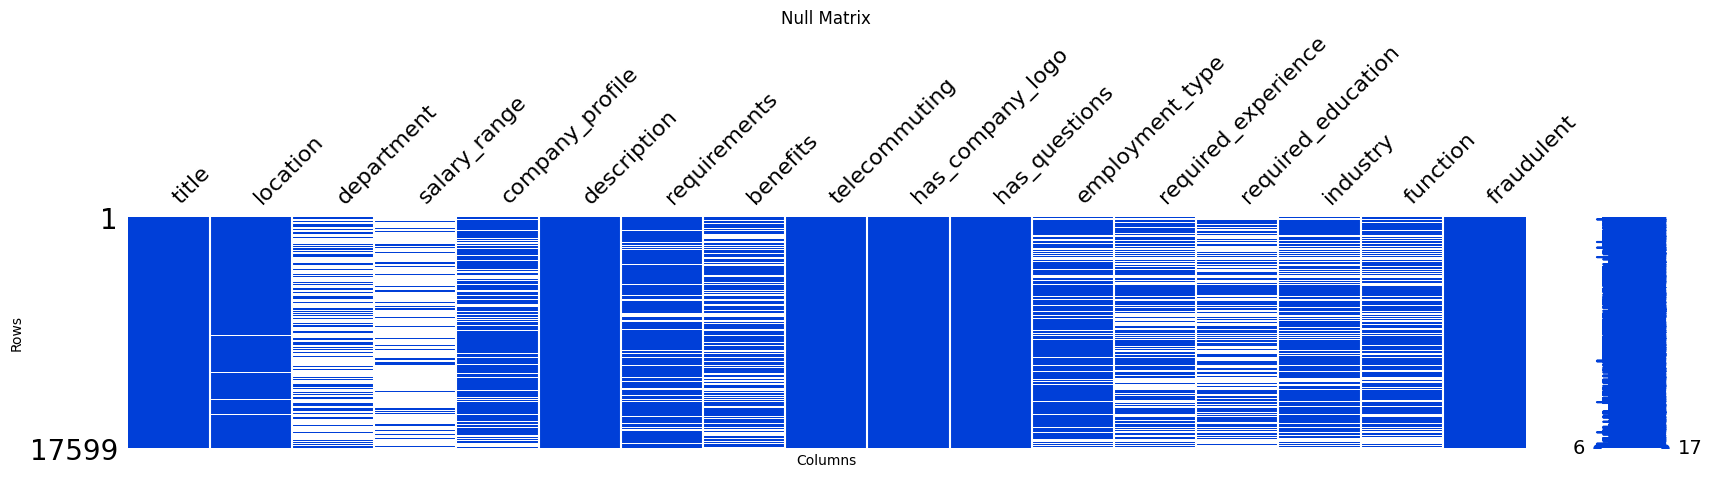

In [10]:
# Plot the null matrix to visualize if there are null values left
msno.matrix(df,figsize=(20, 3),color=(0, 0.25, 0.85))

# Set plot labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Null Matrix')

# Show the plot
plt.show()

Generally when the percentage of missing value in some column is more than 50% it it recommended to drop that column, but let's use another way. Instead of dropping the salary range and ignoring it completely let us create a new binary feature which will have 0 and 1 value representing that whether salary range is given or not.

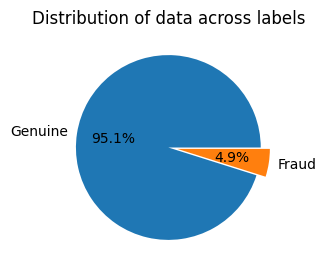

In [11]:
# Let's check the distribution of data across labels 0 -> Genuine and 1 -> Fraud
fig,ax = plt.subplots(figsize = (3,3))

ex = [0.0,0.1]
plt.pie(df['fraudulent'].value_counts(), labels=['Genuine', 'Fraud'],autopct='%1.1f%%',explode = ex)
plt.title("Distribution of data across labels")
plt.show()

### Data cleaning and Processing

- Dealing with missing values
- Dealing with outliers
- Encoding categorical values
- Cretion of embeddings

In [12]:
print("Fraud JD having no department mentioned : "+str(df[df['fraudulent'] == 1]['department'].isnull().sum()))

Fraud JD having no department mentioned : 524


In [13]:
# Let's create a copy of the dataframe and on that copy we will explore various processing techniques 
temp_df = df.copy()

In [14]:
salary_range_present = []

for i in range(len(temp_df['salary_range'])):
    if pd.isna(temp_df['salary_range'].iloc[i]):
        salary_range_present.append(0)  # Salary range not provided
    else:
        salary_range_present.append(1) # Salary range provided

temp_df['Salary_range_provided'] = salary_range_present
temp_df.drop(['salary_range'],inplace=True,axis=1)

Just like for salary_range feature we will do the same thing for the department feature.

In [15]:
department_mentioned = []
for i in range(len(temp_df['department'])):
    if pd.isna(temp_df['department'].iloc[i]):
        department_mentioned.append(0) # Department not provided
    else:
        department_mentioned.append(1) # Department mentioned

temp_df['department_mentioned'] = department_mentioned
temp_df.drop(['department'],inplace=True,axis=1)

In [16]:
# Let's impute the missing values in the location feature using the mode imputation
temp_df['location'] = temp_df['location'].fillna(temp_df['location'].mode()[0])
temp_df = temp_df.dropna(subset = ['description'])

In [17]:
temp_df.drop(['function','title','company_profile','location'],axis=1,inplace=True)

In [18]:
# Let's find out which employment type have most number of fake job postings
fakeJP_emptype = temp_df[temp_df['fraudulent'] == 1].groupby('employment_type').size()
fakeJP_emptype = np.round((fakeJP_emptype/fakeJP_emptype.sum())*100,2)
fakeJP_emptype.sort_values(ascending=True)

employment_type
Temporary     0.32
Other         2.42
Contract      6.94
Part-time    11.77
Full-time    78.55
dtype: float64

In [19]:
# Let's find out which out of all fake job postings what is most common required experience
fakeJP_exp = temp_df[temp_df['fraudulent'] == 1].groupby('required_experience').size()
fakeJP_exp = np.round((fakeJP_exp/fakeJP_exp.sum())*100,2)
fakeJP_exp.sort_values(ascending=True)

required_experience
Executive            2.33
Internship           2.33
Director             3.96
Associate            9.79
Not Applicable      13.99
Mid-Senior level    26.34
Entry level         41.26
dtype: float64

In [20]:
# Let's find out which out of all fake job postings what is most common required experience
fakeJP_edu = temp_df[temp_df['fraudulent'] == 1].groupby('required_education').size()
fakeJP_edu = np.round((fakeJP_edu/fakeJP_edu.sum())*100,2)
fakeJP_edu.sort_values(ascending=True)

required_education
Doctorate                             0.24
Some College Coursework Completed     0.73
Professional                          0.97
Associate Degree                      1.46
Certification                         4.61
Some High School Coursework           4.85
Master's Degree                       7.52
Unspecified                          14.81
Bachelor's Degree                    24.03
High School or equivalent            40.78
dtype: float64

In [21]:
# Which industry have most number of fake job postings ( visualization oh skin tone color wali )
fakeJP_inds = temp_df[temp_df['fraudulent'] == 1].groupby('industry').size()
fakeJP_inds = np.round((fakeJP_inds/fakeJP_inds.sum())*100,2)
fakeJP_inds.sort_values(ascending=False)

industry
Oil & Energy                 18.43
Accounting                    9.73
Hospital & Health Care        8.36
Marketing and Advertising     7.68
Financial Services            5.97
                             ...  
Medical Practice              0.17
Medical Devices               0.17
Food Production               0.17
Airlines/Aviation             0.17
Wholesale                     0.17
Length: 62, dtype: float64

In [22]:
# Dropping the featuers into the original dataframe
df.drop(['function','title','company_profile','location'],axis=1,inplace=True)

In [23]:
salary_range_present = []

for i in range(len(df['salary_range'])):
    if pd.isna(df['salary_range'].iloc[i]):
        salary_range_present.append(0)  # Salary range not provided
    else:
        salary_range_present.append(1) # Salary range provided

df['Salary_range_provided'] = salary_range_present
df.drop(['salary_range'],inplace=True,axis=1)

In [24]:
department_mentioned = []

for i in range(len(df['department'])):
    if pd.isna(df['department'].iloc[i]):
        department_mentioned.append(0) # Department not provided
    else:
        department_mentioned.append(1) # Department mentioned

df['department_mentioned'] = department_mentioned
df.drop(['department'],inplace=True,axis=1)

# Data Processing and Model training (FEATURE TYPE 1)

In [25]:
# Creating seperate dataframe for the textual features and other features
df1 = df.drop(['description','requirements','benefits'],axis=1)
df2 = df[['description','requirements','benefits','fraudulent']]

In [26]:
# Saving the textual features dataframe seperately
df2.to_csv('../Dataset/Job_text_features.csv')

In [27]:
subset_data_cols = ['employment_type', 'required_experience', 'required_education','industry','fraudulent']

# Subset of data for KNN imputer
Subset_df = df1[subset_data_cols].copy()

In [28]:
# Instantiating Ordinal encoder class
oe_exp = OrdinalEncoder(categories = [['Not Applicable','Internship','Entry level','Mid-Senior level','Associate','Director','Executive']],
                        handle_unknown='use_encoded_value',unknown_value=np.nan)

oe_emptype = OrdinalEncoder(categories = [['Other','Temporary','Part-time','Contract','Full-time']],
                        handle_unknown='use_encoded_value',unknown_value=np.nan)

oe_edu = OrdinalEncoder(categories = [["Unspecified", "Some High School Coursework", "High School or equivalent", "Some College Coursework Completed", "Vocational",
     "Vocational - HS Diploma", "Vocational - Degree", "Associate Degree", "Certification", "Professional", "Bachelor's Degree", "Master's Degree", "Doctorate"]],
                   handle_unknown='use_encoded_value',unknown_value=np.nan)      

# Instantiating the target encoder class
te_industry = ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan',return_df=False)

In [29]:
Subset_df['required_experience'] = pd.Series(oe_exp.fit_transform(Subset_df['required_experience'].values.reshape(-1,1)).reshape(-1))
Subset_df['required_education'] = pd.Series(oe_edu.fit_transform(Subset_df['required_education'].values.reshape(-1,1)).reshape(-1))
Subset_df['employment_type'] = pd.Series(oe_emptype.fit_transform(Subset_df['employment_type'].values.reshape(-1,1)).reshape(-1))

y = Subset_df['fraudulent'].values.reshape(-1,1)
Subset_df['industry'] = pd.Series(te_industry.fit_transform(Subset_df['industry'].values.reshape(-1,1),y).reshape(-1))

In [30]:
knn_imputer = KNNImputer(n_neighbors=5, metric='nan_euclidean')

Subset_df = knn_imputer.fit_transform(Subset_df)
Subset_df = pd.DataFrame(Subset_df,columns = subset_data_cols)

In [31]:
df1.drop(subset_data_cols,inplace=True,axis=1)

df1.reset_index(drop=True,inplace=True)
Subset_df.reset_index(drop=True,inplace=True)

# Concatinating the dataframes
df1 = pd.concat([df1,Subset_df],axis=1,ignore_index=False)

In [32]:
# Column transformer for doing feature scaling
scaling_transformer = ColumnTransformer(transformers = [
    ('MinMaxScaling',MinMaxScaler(copy=False),[5,6,7,8])],remainder='passthrough')


# Stacking column transformers to create a Processing pipeline
Processing_pipeline = Pipeline(steps = [('Scaling',scaling_transformer)],memory='Temp')

In [33]:
X = df1.drop(['fraudulent'],axis=1)
y = df1['fraudulent']

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size= 0.8)

In [34]:
X_train_temp = Processing_pipeline.fit_transform(X_train)

### Method 1: Correlation analysis

In [35]:
Temp_df = pd.concat([X_train,y_train],axis=1)

In [37]:
Corr_df = Temp_df.corr()['fraudulent'].to_frame().reset_index().rename(columns={'index':'Features','fraudulent':'Correlation_Coefficient'})
Corr_df

,Features,Correlation_Coefficient
0,telecommuting,0.033560
1,has_company_logo,-0.262079
2,has_questions,-0.090526
3,Salary_range_provided,0.062529
4,department_mentioned,0.019285
5,employment_type,-0.000794
6,required_experience,-0.062366
7,required_education,0.013389
8,industry,-0.026283
9,fraudulent,1.000000


### Method 2: Random Forest Feature Importance

In [39]:
Rf_Model = RandomForestClassifier(n_estimators=100, random_state=42)
Rf_Model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [40]:
Rf_Model_FI_df = pd.DataFrame({'Features': X_train.columns,'RF_Importance': Rf_Model.feature_importances_})
Rf_Model_FI_df.sort_values(by='RF_Importance', inplace=True, ascending=False)
Rf_Model_FI_df

,Features,RF_Importance
8,industry,0.308446
6,required_experience,0.248991
7,required_education,0.176113
5,employment_type,0.123441
1,has_company_logo,0.068649
4,department_mentioned,0.022364
2,has_questions,0.021748
3,Salary_range_provided,0.018789
0,telecommuting,0.011459


### Method 3 : Gradient Boosting Feature importances

In [41]:
Gb_Model = GradientBoostingClassifier()
Gb_Model.fit(X_train, y_train)

Gb_Model_FI_df = pd.DataFrame({'Features': X_train.columns,'GB_Importance': Gb_Model.feature_importances_})
Gb_Model_FI_df.sort_values(by='GB_Importance', inplace=True, ascending=False)
Gb_Model_FI_df

,Features,GB_Importance
6,required_experience,0.390787
5,employment_type,0.275700
1,has_company_logo,0.157817
8,industry,0.105248
7,required_education,0.047105
4,department_mentioned,0.009945
3,Salary_range_provided,0.005658
2,has_questions,0.005372
0,telecommuting,0.002369


### Method 4 - Permutation Importance

In [45]:
# Calculate Permutation Importance
Perm_importance = permutation_importance(Rf_Model, X_test, y_test, n_repeats=30, random_state=42)

Perm_importance_df = pd.DataFrame({'Features': X_train.columns,'Perm_importance': Perm_importance.importances_mean})
Perm_importance_df.sort_values(by='Perm_importance', inplace=True, ascending=False)
Perm_importance_df

,Features,Perm_importance
6,required_experience,1.567235e-02
8,industry,1.125000e-02
7,required_education,3.399621e-03
4,department_mentioned,2.736742e-03
5,employment_type,1.136364e-03
3,Salary_range_provided,5.113636e-04
1,has_company_logo,3.700743e-18
2,has_questions,-3.314394e-04
0,telecommuting,-7.386364e-04


### Method 5: SHAP

In [ ]:
explainer = shap.TreeExplainer(Rf_Model)
shap_values = explainer.shap_values(X_train)

# Summing the absolute SHAP values across all samples to get an overall measure of feature importance
shap_sum = np.abs(shap_values).mean(axis=0)

Shap_df = pd.DataFrame({'Features': X_train.columns,'Shap_importance': np.abs(shap_values).mean(axis=0)})
Shap_df.sort_values(by='Shap_importance', inplace=True, ascending=False)
Shap_df

### Method 6: Recrusive feature elimination

In [ ]:
# Apply RFE on the label-encoded and standardized training data
selector_label = RFE(Rf_Model, n_features_to_select=X_train.shape[1], step=1)
selector_label = selector_label.fit(X_train, y_train)

# Get the selected features based on RFE
selected_features = X_train.columns[selector_label.support_]

# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefficients = selector_label.estimator_.feature_importances_

# Organize the results into a DataFrame
RFE_df = pd.DataFrame({'Features': selected_features,'RFE_importance': selected_coefficients})
RFE_df.sort_values(by='RFE_importance', inplace=True, ascending=False)
RFE_df

In [ ]:
# Merging the results of all the techniques into single data frame
FI_df = Corr_df.merge(Rf_Model_FI_df,on='Features').merge(Gb_Model_FI_df,on='Features').merge(Perm_importance_df,on='Features').merge(Shap_df,on='Features').merge(RFE_df,on='Features')

# Extracting only the technique values
FI_df_Results = FI_df[FI_df.columns[1:]]

# Let's normalize the values
FI_df_Results = FI_df_Results.divide(FI_df_Results.sum(axis=0), axis=1)
FI_df_Results.insert(0,'Features',FI_df['Features'])
FI_df_Results

In [ ]:
fig,ax = plt.subplots(2,3,figsize = (15,9))

sns.barplot(x =FI_df_Results['Features'],y = FI_df_Results['Correlation_Coefficient'],ax = ax[0][0])
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=90)

sns.barplot(x =FI_df_Results['Features'],y = FI_df_Results['RF_Importance'],ax = ax[0][1])
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=90)

sns.barplot(x =FI_df_Results['Features'],y = FI_df_Results['GB_Importance'],ax = ax[0][2])
ax[0][2].set_xticklabels(ax[0][2].get_xticklabels(), rotation=90)

sns.barplot(x =FI_df_Results['Features'],y = FI_df_Results['Perm_importance'],ax = ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=90)

sns.barplot(x =FI_df_Results['Features'],y = FI_df_Results['Shap_importance'],ax = ax[1][1])
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=90)

sns.barplot(x =FI_df_Results['Features'],y = FI_df_Results['RFE_importance'],ax = ax[1][2])
ax[1][2].set_xticklabels(ax[1][2].get_xticklabels(), rotation=90)

plt.subplots_adjust(hspace=0.6)
plt.show()

# Model selection

In [63]:
def scorer(model_name, model):
    """
    This function will take a model name as input and inject that model into the training pipeline to process 
    and train the model using the training data. After that, this function will use K-fold cross-validation technique
    to calculate the average classification metrics and make predictions on the test data to calculate the F1-score.
    """
    
    output = []
    output.append(model_name)
    
    # Stacking column transformers to create a Training pipeline
    Training_pipeline = Pipeline(steps=[
        ('Scaling', scaling_transformer),
        ('classifier', model)
    ])
    
    # Define scoring functions with zero_division=1
    scorer_precision = make_scorer(precision_score, zero_division=1)
    scorer_recall = make_scorer(recall_score, zero_division=1)
    scorer_f1 = make_scorer(f1_score, zero_division=1)
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracy_scores = cross_val_score(Training_pipeline, X_train, y_train, cv=kfold, scoring='accuracy')
    precision_scores = cross_val_score(Training_pipeline, X_train, y_train, cv=kfold, scoring=scorer_precision)
    recall_scores = cross_val_score(Training_pipeline, X_train, y_train, cv=kfold, scoring=scorer_recall)
    f1_scores = cross_val_score(Training_pipeline, X_train, y_train, cv=kfold, scoring=scorer_f1)
    
    output.append(accuracy_scores.mean())
    output.append(precision_scores.mean())
    output.append(recall_scores.mean())
    output.append(f1_scores.mean())
    
    return output

### Model selection

In [64]:
classification_model_dict = {
    'logistic_regression': LogisticRegression(),
    'svm': SVC(),
    'knn': KNeighborsClassifier(),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'gradient_boosting': GradientBoostingClassifier(),
    'adaboost': AdaBoostClassifier(),
    'gaussian_nb': GaussianNB(),
    'mlp': MLPClassifier(),
    'xgboost': XGBClassifier()
}

In [65]:
%%time
model_output = []
for model_name,model in classification_model_dict.items():
    model_output.append(scorer(model_name, model))

C:\Users\ropar_i9941t3\miniconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\ropar_i9941t3\miniconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\ropar_i9941t3\miniconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\ropar_i9941t3\miniconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

CPU times: total: 51min 28s
Wall time: 10min 15s


In [66]:
model_df = pd.DataFrame(model_output, columns=['name','accuracy','precision','recall','f1_score'])
model_df.sort_values(['accuracy'])

,name,accuracy,precision,recall,f1_score
7,gaussian_nb,0.914696,0.150685,0.170973,0.159927
0,logistic_regression,0.952341,0.800000,0.000000,0.000000
1,svm,0.952483,1.000000,0.000000,0.000000
3,decision_tree,0.962000,0.618142,0.538006,0.567250
8,mlp,0.964628,0.871759,0.293518,0.429240
2,knn,0.967966,0.820099,0.423347,0.554398
6,adaboost,0.971518,0.947769,0.425747,0.582726
4,random_forest,0.971802,0.834776,0.500287,0.625619
5,gradient_boosting,0.973577,0.971315,0.456948,0.618007
9,xgboost,0.974643,0.889664,0.532513,0.664745


In [79]:
X_train = Processing_pipeline.fit_transform(X_train)
X_test = Processing_pipeline.transform(X_test)

In [81]:
# Defining the domain space
space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': 180,
    'seed': 0
}

def objective(space):
    model = XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=int(space['min_child_weight']),
        random_state=space['seed']
    )

    # Training the model
    model.fit(X_train, y_train)

    # Getting predictions from the trained model and computing F1-score
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred,zero_division=1)
    print("F1-score:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [82]:
trials = Trials()
best_hyperparams = fmin(fn=objective,space=space,algo=tpe.suggest,max_evals=100,trials=trials)

F1-score:                                                                                                              
0.5977859778597786                                                                                                     
F1-score:                                                                                                              
0.599250936329588                                                                                                      
F1-score:                                                                                                              
0.6022304832713755                                                                                                     
F1-score:                                                                                                              
0.6148148148148148                                                                                                     
F1-score:                               

In [83]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9751476145162237, 'gamma': 0.03437535417938986, 'max_depth': 6.0, 'min_child_weight': 9.0, 'reg_alpha': 0.017624177003629116, 'reg_lambda': 0.23674092818043876}


In [86]:
# Create the XGBoost Regressor with the best hyperparameters
classifier = XGBClassifier(
        n_estimators=int(180),
        max_depth=int(best_hyperparams['max_depth']),
        gamma=best_hyperparams['gamma'],
        reg_alpha=best_hyperparams['reg_alpha'],
        reg_lambda=best_hyperparams['reg_lambda'],
        colsample_bytree=best_hyperparams['colsample_bytree'],
        min_child_weight=int(best_hyperparams['min_child_weight']),
        random_state=space['seed']
    )

# Training the model
classifier.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9751476145162237, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.03437535417938986,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [87]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(classifier, X_train, y_train, cv=kfold, scoring='accuracy')
print("Average Accuracy SCORE : ",scores.mean())

Average Accuracy SCORE :  0.9754242181947406


In [88]:
# Specify the file path where you want to save the model
model_path = '../Artifacts/xgboost_classifier_model.bin'

# Save the model to the specified file
classifier.save_model(model_path)

C:\Users\ropar_i9941t3\miniconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:54:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [89]:
# Save the processing pipeline to a file
with open('../Artifacts/Processing_pipeline.pkl', 'wb') as f:
    pickle.dump(Processing_pipeline, f)

In [90]:
# Save the encoding objects 
with open('../Artifacts/oe_exp.pkl', 'wb') as f:
    pickle.dump(oe_exp, f)

with open('../Artifacts/oe_emptype.pkl', 'wb') as f:
    pickle.dump(oe_emptype, f)

with open('../Artifacts/oe_edu.pkl', 'wb') as f:
    pickle.dump(oe_edu, f)

with open('../Artifacts/te_industry.pkl', 'wb') as f:
    pickle.dump(te_industry, f)

In [33]:
X_train.head(5)

,telecommuting,has_company_logo,has_questions,Salary_range_provided,department_mentioned,employment_type,required_experience,required_education,industry
13313,0,1,0,0,1,4.0,1.8,7.4,0.021053
3627,0,1,1,1,0,4.0,2.0,0.0,0.000000
12497,0,1,0,0,1,4.0,5.0,0.0,0.000000
5341,0,1,1,0,0,4.0,2.2,4.0,0.024335
6477,0,1,1,1,0,4.0,3.0,8.4,0.055012
